In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import seaborn as sns
import json

# Part 1 - Exploratory Data Analysis
## Checking the timestamps entries
The data consist of 93142 timestamps of user logins with no missing entries.

In [2]:
logins = pd.read_json('logins.json')

In [3]:
print("Columns:", logins.columns)
print("Number of missing entries:", logins.isnull().sum())
print("Shape of data:", logins.shape)

Columns: Index(['login_time'], dtype='object')
Number of missing entries: login_time    0
dtype: int64
Shape of data: (93142, 1)


The timestamps span from January 1, 1970 to April 13, 1970, which is a span of 101 days.  

In [4]:
logins['login_time'] = pd.to_datetime(logins.login_time)

In [5]:
print("First login time:", logins.login_time.min())
print("Last login time:", logins.login_time.max())

First login time: 1970-01-01 20:12:16
Last login time: 1970-04-13 18:57:38


In [6]:
span = (logins.login_time.max()-logins.login_time.min())
print("Span of", span.days, "days")

Span of 101 days


## Aggregating the Logins

We aggregate the counts based on 15-minute time intervals, and extract the month, hour and week day for each count.

In [7]:
logins.sort_values(by='login_time',inplace=True)
logins['counts'] = 1
logins = logins.set_index('login_time').resample('15T').sum().reset_index()

In [8]:
logins['month'] = logins['login_time'].apply(lambda s:s.month)
logins['hour'] = logins['login_time'].apply(lambda s:s.hour)
logins['day'] = logins['login_time'].apply(lambda s:s.day_name())
logins['week'] = logins['login_time'].apply(lambda s:s.week)

We also compute the moving average of the counts, which can help us in identifying any overall trend.

In [9]:
logins['rolling_mean'] = logins['counts'].rolling(window=24*4).mean()

## Plotting the Login Activity

We plot the resulting time series of login counts and its moving average (window size 24 hours).

C:\Users\User\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


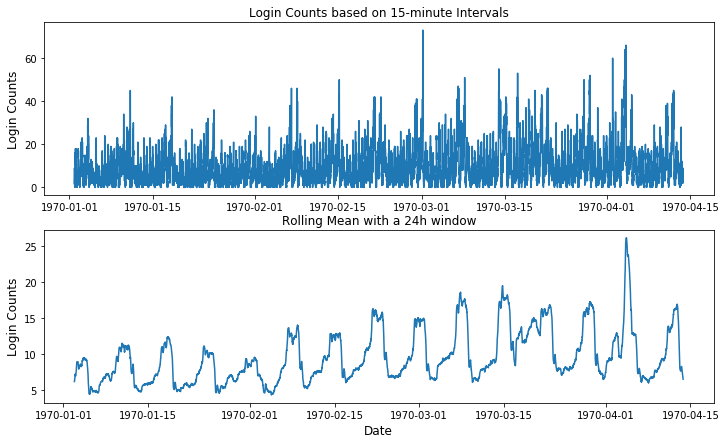

In [10]:
fig, axes = plt.subplots(2,1,figsize=(12,7))

axes[0].plot(logins.login_time, logins.counts)
axes[0].set_title("Login Counts based on 15-minute Intervals",fontsize=12)
axes[0].set_ylabel("Login Counts",fontsize=12)

axes[1].plot(logins.login_time, logins.rolling_mean)
axes[1].set_title("Rolling Mean with a 24h window")
axes[1].set_xlabel("Date",fontsize=12)
axes[1].set_ylabel("Login Counts",fontsize=12)

plt.show()

If we focus on the first plot of login counts, we can see an underlying oscillating pattern behavior, where the number of logins increases for some period of time and then decreases for another subsequent period of time and the pattern repeats. We also notice repeating spikes in the login activity of users, and the magnitudes of spikes after day 55 are greater than those achieved before day 55. The second plot shows the rolling mean of the login counts (window size: 24 hours), which shows the repeating appearance of spikes; in particular, we can notice two major spikes in any period of 15 days. We also notice an overall positive shift or increase in the login counts in the last two months. Let us now zoom in each month of the login activity.

## Monthly Login Activity

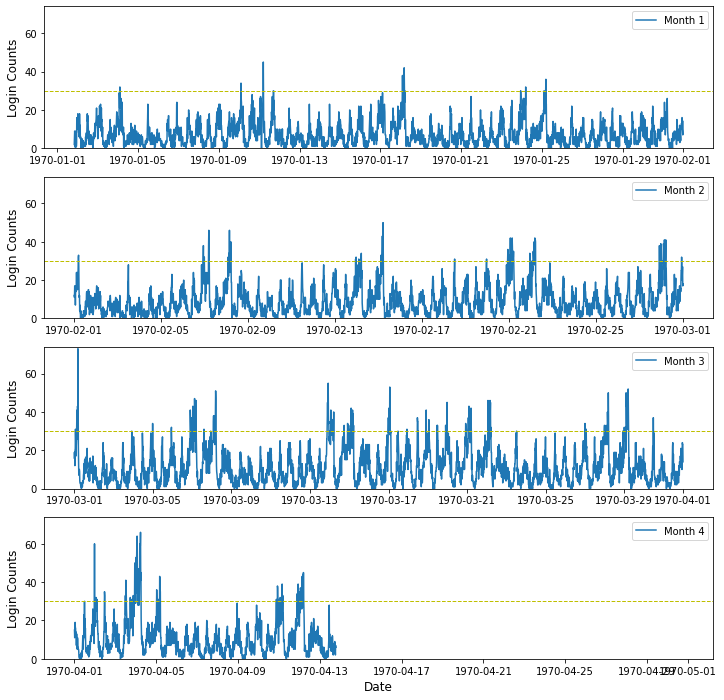

In [11]:
months = range(1,5)
fig, axes = plt.subplots(4,1,figsize=(12,12))

for m, ax in zip(months,axes):
    ax.plot(logins[logins.month==m].login_time, logins[logins.month==m].counts, 
            label="Month {}".format(m))
    ax.axhline(30, linewidth=1, linestyle='--', color='y')
    ax.set_ylim([0,logins.counts.max()+1])
    ax.set_ylabel("Login Counts",fontsize=12)
    ax.legend(loc="upper right")
axes[-1].set_xlim([dt.datetime(1970,3,30,12),dt.datetime(1970,5,2,6)])
axes[-1].set_xlabel("Date", fontsize=12)
plt.show()

We now notice more closely the oscillations in user login activity during each month. For any period of 15 days, we notice more than 15 times increase in the login activity, which means that per one day there might be more than one surge in the login activity of users. We also notice that spikes with high values are more noticeable in the third month, where there is an overall increase in users activity compared to the last two months. The below box plot summarizes the range of login counts for each month, where we again notice the gradual increase in the values of counts and their range throughout the months. Note that for the month of April, we only have the login counts for the first half of the month and the range of values is already larger than the those of January and February. 

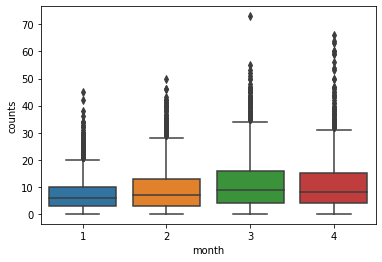

In [12]:
g = sns.boxplot(x="month", y="counts", data=logins)

## Daily and Hourly Login Activity

The previous plots show the presence of daily and weekly cycles in the users' login activity, which we now closely examine. For each day of the week, we take some samples from each month.

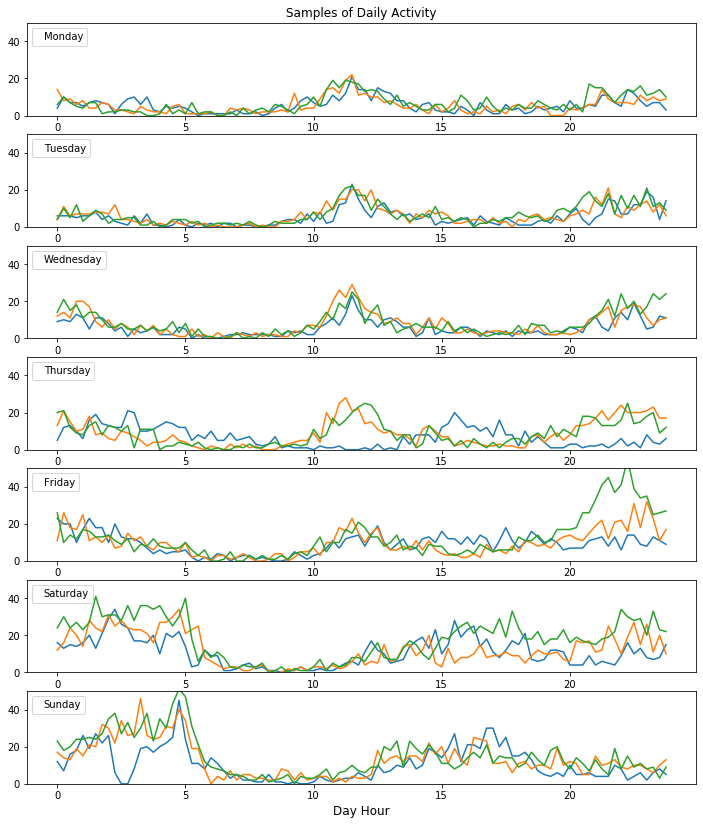

In [13]:
import matplotlib.dates as md

days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
fig, axes = plt.subplots(7,1,figsize=(12,14))

for d, ax in zip(days,axes):
    for m in [1,2,3]:
        subset = logins[(logins.month ==m) & (logins.day==d)].iloc[(24*4):2*(24*4)]
        ax.plot(np.linspace(0,24,24*4+1)[:-1],subset.counts)
        ax.set_ylim([0,50])
    ax.lines[-1].set_label(d)
    ax.legend(handlelength=0, loc='upper left')
axes[-1].set_xlabel("Day Hour", fontsize=12)
axes[0].set_title("Samples of Daily Activity",fontsize=12)
plt.show()

From these daily samples, we directly notice some differences in the login activity between a weekday and weekend. In a weekday, the main increase in users activity occur at around 11 am. On the other hand, in a weekend, the main increase occur after midnight. Since fluctuations in the user activity can occur from one day to another, we focus instead on the summaries of the daily activity  of all weekdays and weekends, by plotting the boxplot of login counts for each hour of each week day.

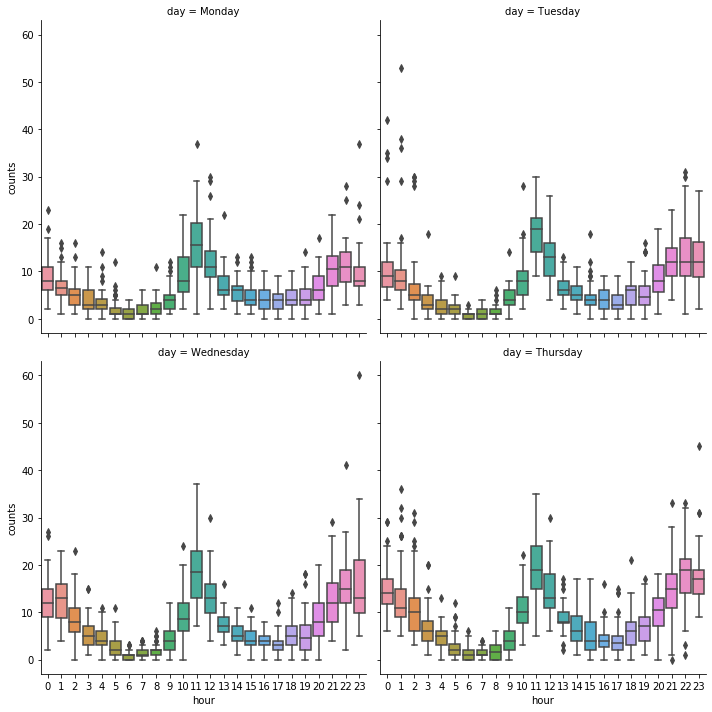

In [14]:
import seaborn as sns
days = ["Monday", "Tuesday", "Wednesday", "Thursday"]
g= sns.catplot(x="hour",y="counts",data=logins, 
               kind='box', col="day",col_wrap=2, col_order=days)
plt.show()

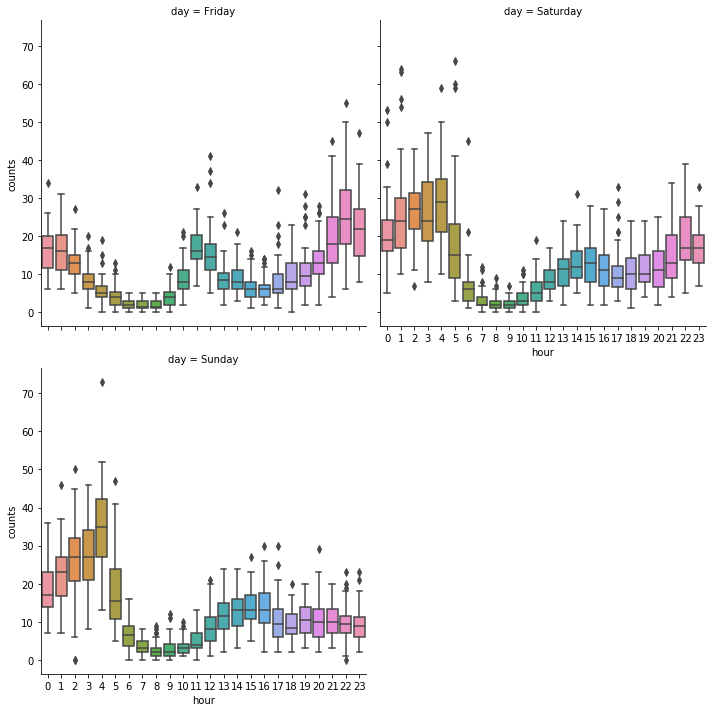

In [15]:
days = ["Friday","Saturday","Sunday"]
g= sns.catplot(x="hour",y="counts",data=logins, 
               kind='box', col="day",col_wrap=2, col_order=days)

The key features of the daily login activity can be summarized as follows:
- *Weekday*: weekdays start with an after midnight gradual decrease in the activity of users, which reaches its lowest value in the early morning hours (5am to 7am). Then the login counts start to increase to reach its maximum at 11am (around lunch time) before it again starts to decrease and then settle in the afternoon (4pm to 5pm). At the end of the day, the activity increases again at night (9pm-12am). This latter increase in the users' activity at night is more noticeable on Friday night than on any other weekday.
- *Weekend*: weekends start with a gradual increase in the users activity after 12am to reach its maximum at 4am. Then, a rapid decrease in the login activity follows. The login activity stays low during the morning of each weekend before it again increases in the afternoon (3pm-4pm). On Saturday, another substantial increase in the login acctivity occurs at night after 9pm. On Sunday, there is no increase in login activity at those times, the login activity stays low and less variant at night on Sunday. 

These key features can be again observed in the boxplot below, that summarizes the values of login counts for all weekdays and weekends. It is also worth to mention that the highest values of the login counts correspond to weekends (people are more active in the weekends), which explains the repeating appearances of high-value spikes that we have noticed in the first plot.

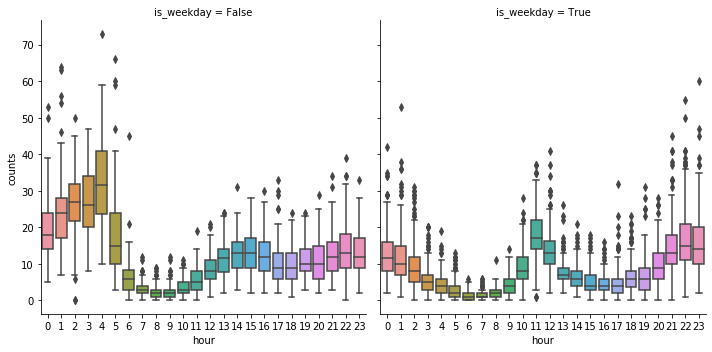

In [16]:
days = ["Monday", "Tuesday", "Wednesday", "Thursday","Friday"]
logins["is_weekday"] = logins.day.isin(days)
g= sns.catplot(x="hour",y="counts",data=logins, 
               kind='box', col="is_weekday")

# Part 2 - Experiment and Metrics Design

We denote by A the city that is most active at night and by B the city that is most active during the day in a weekday.

1. *What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?*

I would choose as metric: the maximum percentage of working time spent in either city per driver.

The problem states that drivers tend to be exclusive to each city. So I am assuming there are two groups of drivers: drivers who spend all of their working time in city A and drivers who spend all of their working time in city B. This implies that the maximum percentage of time spent in either city per driver is 100%. Since the target is to encourage drivers to serve both cities, we can check if drivers are serving both cities by measuring the maximum percentage of time spent in either city per driver and see if it has decreased.

During any day of the experiment, when drivers turn on the App to start taking trips, we can get a record of the locations of the driver with the timestamps. At the end of the experiment, we will have for each user, all the timestamps with the corresponding locations. We exclude any locations that do not belong to cities A or B. Then we compute for each user the percentage of time spent in city A and in city B, we then pick the maximum of these two percentages for each user.

2. *Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on*: *how you will implement the experiment? b. what statistical test(s) you will conduct to verify the significance of the observation?* c. *how you would interpret the results and provide recommendations to the city operations team along with any caveats?*

We randomly select a sample of drivers from city A, we provide half of the sample with the option of reimbursing all toll costs. We also randomly select a sample of the same size of drivers from city B and we provide half of the samples with the option of toll cost reimbursement. And we run the experiment for some number of days. An important factor that must be taken into consideration is the time during which we run the experiment. This is because during the day of a weekday, city B is more active, therefore more demand will occur in that city, this will make the drivers of city B stay in their city because of the demand and in this case we will not correctly capture the effectiveness of the proposed change. Similarly, at night, city A is more active, drivers of city A are more encouraged to stay in their city because of the demand and moreover, drivers of city B might not be willing to work at night. The solution is to run the experiment only during the weekend to avoid any biases. Or we can additionally run two experiments, in the first experiment, we only focus on drivers of city B, we provide them with the option of free toll at night and compute the percentage of time spent by the drivers in each city. In the second experiment, we only focus on the drivers of city A, we provide them with the option of free toll during the day and compute the percentage of time spent by the drivers in each city.
    
For each experiment we perform hypothesis testing to test the significance of the result. For instance, if we focus on the first experiment that is run only in weekends, we will end up with all of the metrics computed for all users of both cities for the control and test groups. We then perform t-test, by first computing the mean of all obtained percentages for each group: control and test (we sum the measures of all drivers within each group and then divide by the total number of drivers of each group). We then compute the difference between the two means and perform 1 side t-test, this is because we are looking for a decrease in the maximum percentage of time spent in either city. If the assumptions of t-test do not hold, we can perform a permutation test. We finally choose a level of significance (0.05 or 0.01) and then find the p-value of the experiment and compare it to our level of significance. We will then either reject the null hypothesis (no difference between the means) or fail to reject the null hypothesis. We repeat the t-test for each experiment. If the tests were significant, we then report our results to the city operations team. If not, we might need to collect more samples and do more testing, or try to propose another feature.

# Part 3 - Predictive Modeling

The answer to this part consists of three sections. In the first section, we explore the data by checking the statistics of its columns and checking the presence of any missing values, outliers or any issues with the data. In the second section, we visualize the features of the data and check for any pattern or trend with respect to our target variable (whether the user was active or not in the past 30 days). In the third section, we describe the steps of building the predictive model and finish with the insights provided by the model.

## Data Exploration

We load the data into a pandas dataframe.

In [17]:
data = [json.loads(line) for line in open('ultimate_data_challenge.json')]
data_df = pd.DataFrame(data[0])

The data consists of 50000 rows and 12 columns.

In [18]:
data_df.shape

(50000, 12)

In [19]:
data_df.columns

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver'],
      dtype='object')

The data consists of a mix of numerical and categorical columns. 

**Categorical Columns:** Let us first start with the categorical columns by checking their unique values.

In [20]:
cat_cols = ['city', 'phone', 'ultimate_black_user']
for col in cat_cols:
    print("Column:", col)
    print(data_df[col].value_counts())
    print("Number of missing entries:", data_df[col].isnull().sum())
    print('------')

Column: city
Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64
Number of missing entries: 0
------
Column: phone
iPhone     34582
Android    15022
Name: phone, dtype: int64
Number of missing entries: 396
------
Column: ultimate_black_user
False    31146
True     18854
Name: ultimate_black_user, dtype: int64
Number of missing entries: 0
------


We notice that the column "phone" has 396 missing entries. Since we do not have additional information related to this category, we label those missing entries as "unknown".

In [21]:
data_df['phone'].fillna("unknown",inplace=True)

**Numerical Columns:** We now check the statistics of the numerical columns of the data.

In [22]:
data_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [23]:
for col in data_df.columns:
    if (data_df[col].isnull().sum()>0):
        print("Number of missing entries in the column '{}': {}".format(col, data_df[col].isnull().sum()))

Number of missing entries in the column 'avg_rating_of_driver': 8122
Number of missing entries in the column 'avg_rating_by_driver': 201


**Missing Entries**:
We notice some missing values in the columns: avg_rating_of_driver and avg_rating_by_driver. Some of those missing entries might be due to that fact that some users or drivers do not provide any rating. We will impute later those missing entries with the median of their corresponding columns, as part of the model building pipeline.
 
**Some Outliers with High Values**:
We also notice in the columns: avg_dist, trips_in_first_30_days, avg_surge and surge_pct, that the maximum values are noticeably greater than the remaining values of the corresponding column. These high values are summarized as follows:

In [24]:
print("Number of rows with the high maximum values:")
for col in ["avg_dist", "trips_in_first_30_days", "avg_surge", "surge_pct"]:
    print("Column: {}, Maximum Value: {}, Number of instances: {}".format(
        col, data_df[col].max(), sum(data_df[col] == data_df[col].max())))

Number of rows with the high maximum values:
Column: avg_dist, Maximum Value: 160.96, Number of instances: 1
Column: trips_in_first_30_days, Maximum Value: 125, Number of instances: 1
Column: avg_surge, Maximum Value: 8.0, Number of instances: 1
Column: surge_pct, Maximum Value: 100.0, Number of instances: 1416


The first three maximum values as listed above appear each in one instance in the data, which might correspond to a rare event. We decide to remove these three maximum  values, which can later help in better interpreting the final mode. The last maximum values appear in more than one instance and can represent  a reasonable value (for instance, if a rider always asks for a ride during rush hours, all his trips will then be taken when the surge multiplier is greater than 1).

In [25]:
where_to = (data_df.trips_in_first_30_days < data_df.trips_in_first_30_days.max()) & (
    data_df.avg_surge < data_df.avg_surge.max()) & (data_df.avg_dist < data_df.avg_dist.max())
data_df = data_df[where_to]

**Some issues**: One last thing we would like to address is the existence of some issues in the data. The column "avg_dist" represents the average distance per trip takes int he first 30 days after the signup. In this case, if no trips were takes in the first 30 days, the average distance should be zero but this is not the case for 15334 instances.

In [26]:
sum((data_df.trips_in_first_30_days==0) & (data_df.avg_dist>0))

15333

This means that there was a mistake here in the data retrieval that should be checked. To proceed with this part, we assume that there is a mistake in the distance computation and we will set the values of "avg_dist" to zeros when there were no trips in the first 30 days.

In [27]:
data_df.at[(data_df.trips_in_first_30_days==0), "avg_dist"]=0

**Adding the indicator column "active"**: We now add the indicator column active, to indicate if the rider took any trip in the last 30 days.

In [28]:
data_df['last_trip_date'] = pd.to_datetime(data_df['last_trip_date'])
max_date = data_df['last_trip_date'].max()
data_df = data_df.assign(active=data_df['last_trip_date'] >= (
    max_date - pd.to_timedelta('30 day')))

In [29]:
print("Proportion of 'active' riders:", sum(data_df.active==1)/len(data_df))

Proportion of 'active' riders: 0.37606256375382524


## Some Visualizations

**Categorical columns**: We plot the bar plot for each unique value of each colum and show how the propotions differ between active and non active riders.

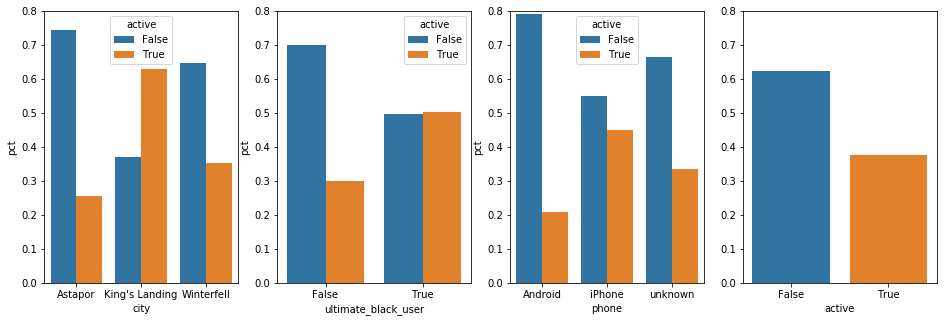

In [30]:
cat_cols = ['city', 'ultimate_black_user', 'phone']
fig, axes = plt.subplots(1, 4, figsize=[16, 5])
for col, ax in zip(cat_cols, axes[:-1]):
    ph = data_df.groupby(col)['active'].value_counts(normalize=True).reset_index(
        [col]).rename(columns={"active": "pct"}).reset_index()
    sns.barplot(col, 'pct', data=ph, hue='active', ax=ax)
    ax.set_ylim([0, 0.8])
sns.barplot(['False', 'True'], [1-sum(data_df.active == 1) /
                                len(data_df), sum(data_df.active == 1)/len(data_df)], ax=axes[-1])
axes[-1].set_ylim([0, 0.8])
axes[-1].set_xlabel('active')
plt.show()

While the last bar plot shows the distribution of active and non active riders in the whole data (63% vs 37%), the first three bar plots show how this ditribution differ if we zoom into each possible category.

**Key Observations**:
-  In the city of King's Landing, the percentage of active riders is higher those of the other two cities; also, the percentage of active and non active riders in the city of Winterfell is very similar to the overall distribution of these two classes (63% vs 37%);
-  Riders who used the ultimate black option have more active riders in percentage than those who did not use the option;
- Riders with Android phone have more non active riders in percentage than those who use iPhone.

**Numerical Columns**: We first plot the box plots of the numerical columns: weekday_pct, avg_surge and surge_pct for active and non active riders, and check for any differences between the two classes.

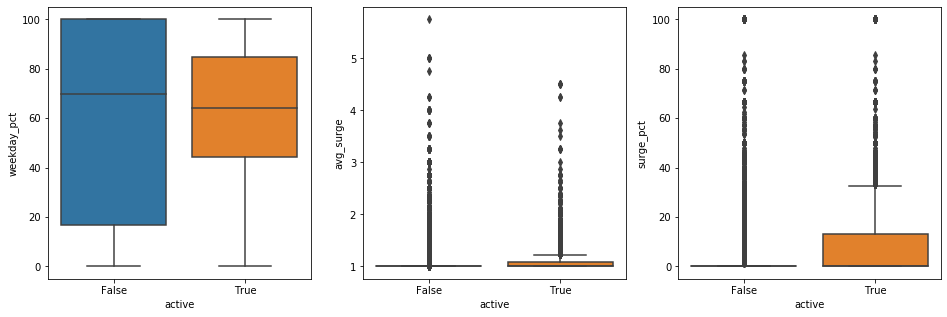

In [31]:
num_cols=['weekday_pct','avg_surge',"surge_pct"]
fig, axes = plt.subplots(1,3,figsize=[16,5])
for col, ax in zip(num_cols,axes):
    sns.boxplot('active',col,data=data_df,ax=ax)
plt.show()

**Key Observations:**
- for all numerical columns, we see a difference between the distribution of the values of the two classes: active and non active;
- for the features: avg_surge and surge_pct, with non active riders, we ntoiced that dirisbution of the vlaues are more right skewed.

One can interpret these observations, is that if active users are taking rides more frequently than non active users, the measures "avg_surge" and "surge_pct" will be smoother and contain less extreme values. This is what we also observe in the below plot; we notice that most of the riders that took 1 trip in the first 30 days are non active riders, and the distances for this first trip spans over the largest span of distance values. On the other hand, most of the riders who took 15 to 40 trips in the first 30 days are active users, and the span of the corresponding average distances is narrower.

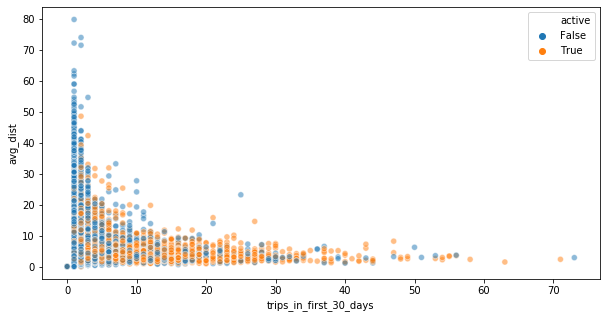

In [32]:
fig, axe = plt.subplots(figsize=[10, 5])
sns.scatterplot('trips_in_first_30_days', 'avg_dist',
                data=data_df, hue='active', alpha=0.5)
plt.show()

**Checking for any Correlation**: Before we proceed to building the predictive model, we check if there is any correlation between the numerical columns.

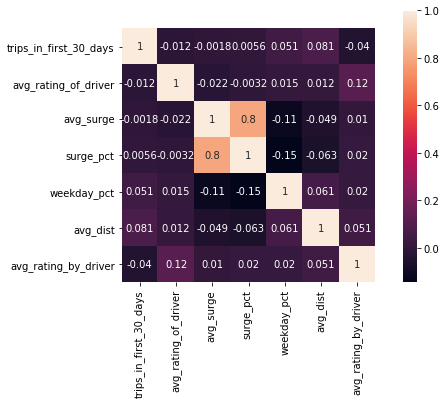

In [33]:
fig, ax = plt.subplots(figsize=(10,5))
mat_corr= (data_df[['trips_in_first_30_days', 'avg_rating_of_driver','avg_surge', 'surge_pct',
                      'weekday_pct', 'avg_dist','avg_rating_by_driver']]).corr()
sns.heatmap(mat_corr,ax=ax,square=True,annot=True)
ax.set_ylim(len(mat_corr),-0.5)
plt.show()

There is no strong correlation between the numerical features, except for the features: surge_pct and avg_surge, that showed stronger correlation.

## Building the Predictive Model

We first extract the features as X, and the target variable as Y.

In [34]:
num_cols = ['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist',
            'avg_rating_by_driver']
cat_cols = ['city', 'phone', 'ultimate_black_user']

X = data_df[num_cols+cat_cols]
Y = data_df['active']

We split the data into 80% for training and 20% for testing. We then build a pipeline that will be used to preprocess the categorical and numerical columns. We encode the categorical columns with one hot encoding, and for numerical columns, we impute the missing entries with the median value and standard scale them.

In [37]:
from sklearn.pipeline import Pipeline
from sklearn import pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0, stratify=Y)

categorical_pipe = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

label_pipe = Pipeline([
    ('label', OrdinalEncoder())])

numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, cat_cols[0:2]),
     ('cat2', label_pipe, [cat_cols[-1]]),
     ('num', numerical_pipe, num_cols)])

We then specify the models that we are going to train. In order to compare between the models, we perform 5-fold cross validation on the training set and compute the mean of accuracy and F1 scores obtained from crossvalidation.

In [38]:
models = [LogisticRegression(random_state=42), DecisionTreeClassifier(random_state=42),
          RandomForestClassifier(random_state=42), 
          GradientBoostingClassifier(random_state=42)]

mnames = ["Logistic Regression", "Decision Tree Classifier", "Random Forest Classifier",
          "Gradient Boosting Classifier"]

for (mname, model) in zip(mnames, models):
    print(mname)
    clf = Pipeline([
        ('preprocess', preprocessing),
        ('classifier', model)
    ])
    scores = cross_validate(clf, X_train, y_train, cv=5, scoring=('accuracy','f1'))
    print("Accuracy:", np.mean(scores['test_accuracy']), "F1:", np.mean(scores["test_f1"]))

Logistic Regression
Accuracy: 0.7221540848856107 F1: 0.5781180186883702
Decision Tree Classifier
Accuracy: 0.7205542974121765 F1: 0.6128808885189417
Random Forest Classifier
Accuracy: 0.76535756032004 F1: 0.6774042592514431
Gradient Boosting Classifier
Accuracy: 0.7853342105263158 F1: 0.6981333595606495


We see that gradient boosting classifier performed best. We choose it as our final model. Before we test our final model on the test set, we fine-tune its parameters using GridSearchCV.

In [40]:
from sklearn.model_selection import GridSearchCV
parameters = {'classifier__learning_rate':[0.1, 0.05, 0.01], 'classifier__n_estimators':[100, 250, 500, 700], 
              'classifier__max_depth':[3,4,5,6,7]}

clf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', models[-1])
])

search = GridSearchCV(clf, parameters,cv=5, n_jobs=3,verbose=1)

In [41]:
search.fit(X_train, y_train)
print(search.best_params_)
print(search.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  7.4min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed: 44.4min
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed: 70.7min finished


{'classifier__learning_rate': 0.05, 'classifier__max_depth': 4, 'classifier__n_estimators': 500}
0.7927596918364795


**Performance of final model:** We now train gradient boosting tree using the found parameters and the complete training set. 

In [46]:
final_model = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', GradientBoostingClassifier(
        learning_rate=0.05, n_estimators=500, max_depth=4, random_state=42))
])
final_model.fit(X_train, y_train)
print("Accuracy of final model", final_model.score(X_test, y_test))

Accuracy of final model 0.7893


**Feature Importance**: we plot the feature importances of the features using the final model.

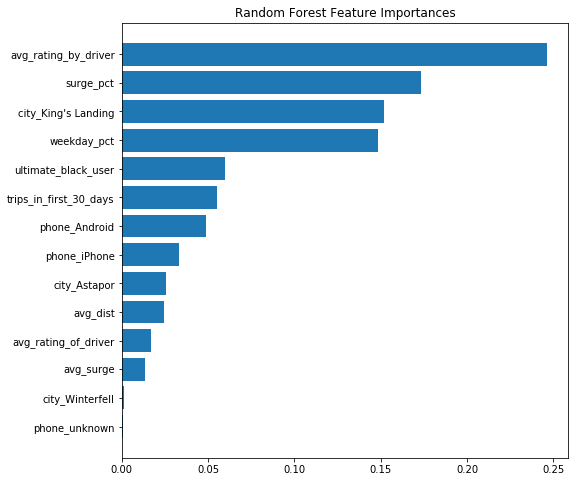

In [47]:
ohe = final_model.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot']
feature_names = ohe.get_feature_names(input_features=cat_cols[0:2])
feature_names = np.r_[feature_names, [cat_cols[-1]], num_cols]

tree_feature_importances = final_model.named_steps['classifier'].feature_importances_
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=[8,8])
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances")
plt.show()

We notice the top 5 important features are: average rating by driver, percentage of trips taken with surge>1, city of King's LAnding, the percentage of weekday trips, and number of trips in first 30 days.

**Shapely Values:** To understand whether  each feature contributed positively or negatively to the target variable, we can compute the shapley values.

In [48]:
import shap
model = final_model.named_steps['classifier']
shap_values = shap.TreeExplainer(model).shap_values(preprocessing.transform(X_train))

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


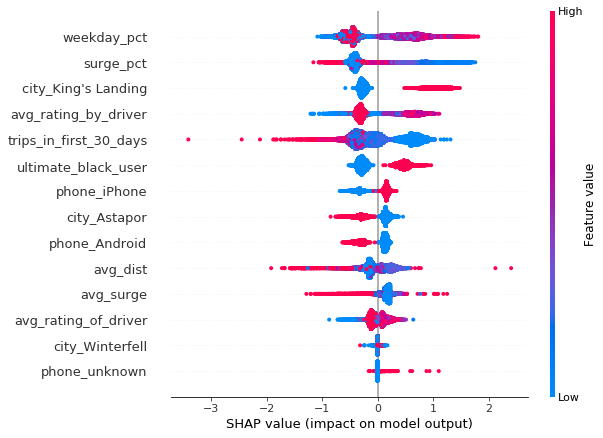

In [49]:
shap.summary_plot(shap_values, pd.DataFrame(preprocessing.transform(X_train),columns=feature_names))

The SHAP values measures the impact of each features on the model output, which is the probability of a user being active. 
- We notice that the high value of city King's Landing (i.e., the user is from the city of King's Landing), as well as that of ultimate black user and iphone, have all positive impact on the model output. On the other hand, having an Android_phone or being in the city of Astapor have negative impact on the model output. 
- We also notice that most of the high values of surge_pct, trips_in_first_30_days, average distance and average surge all have negative impact on the model output.
- We also notice that some of the low rating provided by the drivers have negative impact on the model output.
- The medium values of weekday_pct have positive impact on the model output and the values of surge_pct that have important positive impact are low values.

Based on the insights provided by the analysis and the model:
- it would be helpful to check the compatibility of the mobile app with android system and see if there are any bugs or problems that might be affecting the experience of riders;
- it would be also helpful to check why there are more active users in the city of King's Landing and why there are less active users in the other two cities; what factors are making the riders of the first city stay active and what factors are making riders less active in the other two cities; 
- features like weekday_pct, surge_pct and avg_dist give insight into who is a regular user and who is not; it might be helpful to check with regular users in order to maintain a good user experience for them. Regarding the other users who are likely to be non-active in the future, they might be offered discounts on their trips or provided with incentives (free ride or no price surge for the next trip) to encourage them to take more trips;
- having some high values of "avg_surge" that negatively correlate with the probability of the user being active in the next months, might be because of the fact that the user is not a regular customer and only takes trip occasionally or it might be because of the surge in prices or any other factors. We can't draw any conclusions, therefore it might be helpful to conduct further experiments to understand better how the price surge is affecting user retention.
- the black user option showed a positive correlation with the probability of users being active. It would be also heplful to check what other App features (or design new ones) that could be a good predictor for user retendtion.